# CAB420, Learning Good Representations of Data
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

We can think of a lot of the methods we've looked at in the second part of CAB420 as being concerned with learning a representation of the data.

PCA, LDA, Metric Learning methods, and Auto-Encoders all transform our data from it's original form to some lower dimensional version. The hope is that this lower dimensional version is in some way better for learning. This may be due to it simply being lower dimensional, and thus being easier to work with and helping to avoid overfitting, or perhaps the lower dimensional space removes noisy information that does not contribute to our overall objective (whatever that may be). 

In this summary example, we're going to look at the impact that these various representation methods have on the performance of a simple classifier.

Hopefully, everything in this example will be familar, but if it isn't:
* Ask questions, either in class or online
* Go back and look at the original content in earlier weeks

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import keras
from keras import regularizers
from keras import layers, models
from keras.utils import model_to_dot, plot_model

import numpy
import random
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from sklearn import decomposition, discriminant_analysis

from skimage.feature import hog

## The Data

We're going to use CIFAR-10 here. For the sake of speed and interest, we will:
* Use only 10,000 training samples, and 5,000 testing samples. Feel free to increase these numbers (which will increase the performance we see), but be warned that things will get slow.
* Create a "flat" version of our features to use with PCA and LDA, which require vectorised inputs
* Compute HOG features as well to try with PCA and LDA.

Increasing the number of samples you use (or decreasing it further) will have major impacts on performance. You are encouraged to explore this in your own time.

In [2]:
# load the data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# number of samples to use - change this if you wish, but things might get slow
num_train_samples = 10000
num_test_samples = 5000

# convert to float and scale
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape data, and get only the requested number of samples
x_train = numpy.reshape(x_train, (len(x_train), 32, 32, 3))
x_train = x_train[0:num_train_samples, :, :, :]
y_train = numpy.reshape(y_train, -1)
y_train = y_train[0:num_train_samples]

x_test = numpy.reshape(x_test, (len(x_test), 32, 32, 3))
x_test = x_test[0:num_test_samples, :, :, :]
y_test = numpy.reshape(y_test, -1)
y_test = y_test[0:num_test_samples]

# get flattened representation
x_train_flat = numpy.reshape(x_train, (len(x_train), -1))
x_test_flat = numpy.reshape(x_test, (len(x_test), -1))

# HOG representation
def transform_datset_to_hog(data, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(2, 2)):
    hog_data = []
    for im in range(data.shape[0]):
        hog_data.append(hog(data[im,:,:,:], orientations=orientations, pixels_per_cell=pixels_per_cell,
                            cells_per_block=cells_per_block, visualize=False, channel_axis=2, feature_vector=True))
    return numpy.array(hog_data)

x_train_hog = transform_datset_to_hog(x_train)
x_test_hog = transform_datset_to_hog(x_test)

## A Baseline

Before we start learning things, let's establish a baseline. Here, we'll take just the raw pixel representations (or raw HOG representations) and pass that through our evaluation. We'll use one evaluation function for all models, and this will:
* Plot the test set using t-SNE to help visualise how well separated the classes are (if at all);
* Train a single layer neural network as our simple classifier. This will take whatever input representation we have, and train one dense layer with 10 outputs and a softmax activation - i.e. the simplest possible neural network that we can train in this setting; and plot a confusion matrix for this classifier on the test set.

This evaluation is clearly biased towards classification tasks, as we're looking at class separation in t-SNE (which is good for classification), and how well a simple classifier can separate the data (i.e. classification); so keep in mind that we're not considering the compactness of the representation, or it's utility for other tasks here (though the commentary may addresses these issues from time-to-time).

In [3]:
# evaluation function
#  x_train_embed - Training data, transformed into whatever representation we are using
#  y_train - Training labels
#  x_test_embed - Testing data, transformed into whatever representation we are using
#  y_test - Testing labels
#
def eval_model(x_train_embed, y_train, x_test_embed, y_test):

    # t-sne plot
    # pass embeddings into t-sne
    tsne_embeddings = TSNE(random_state=4).fit_transform(x_test_embed)
    # plot the result
    fig = plt.figure(figsize=[20, 10])
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test);

    # simple classifier
    # single layer NN (note I'm not saying "deep" - we have one layer, this is not deep)
    simple_classifier_model = keras.models.Sequential(
    [
        # input, it's whatever embedding we've been supplied
        keras.Input(shape=(x_train_embed[0,:].shape)),
        # single dense layer, 10 outputs for the 10 classes
        keras.layers.Dense(10, activation="softmax", kernel_regularizer=keras.regularizers.l2(0.02)),
    ])

    # train the classifier
    simple_classifier_model.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", \
                                    metrics=["accuracy"], jit_compile=False)
    simple_classifier_model.fit(x_train_embed, y_train, epochs=10, verbose=False, batch_size=16)

    # plot a confusion matrix for the classifier
    ax = fig.add_subplot(1, 2, 2)    
    indexes = keras.ops.argmax(simple_classifier_model.predict(x_test_embed, verbose=False, batch_size=16), axis=1)
    cm = confusion_matrix(y_test, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
    # get F1-score for the classifier
    ax.set_title('F1 Score: %1.3f' % f1_score(y_test, indexes, average='weighted'))
    

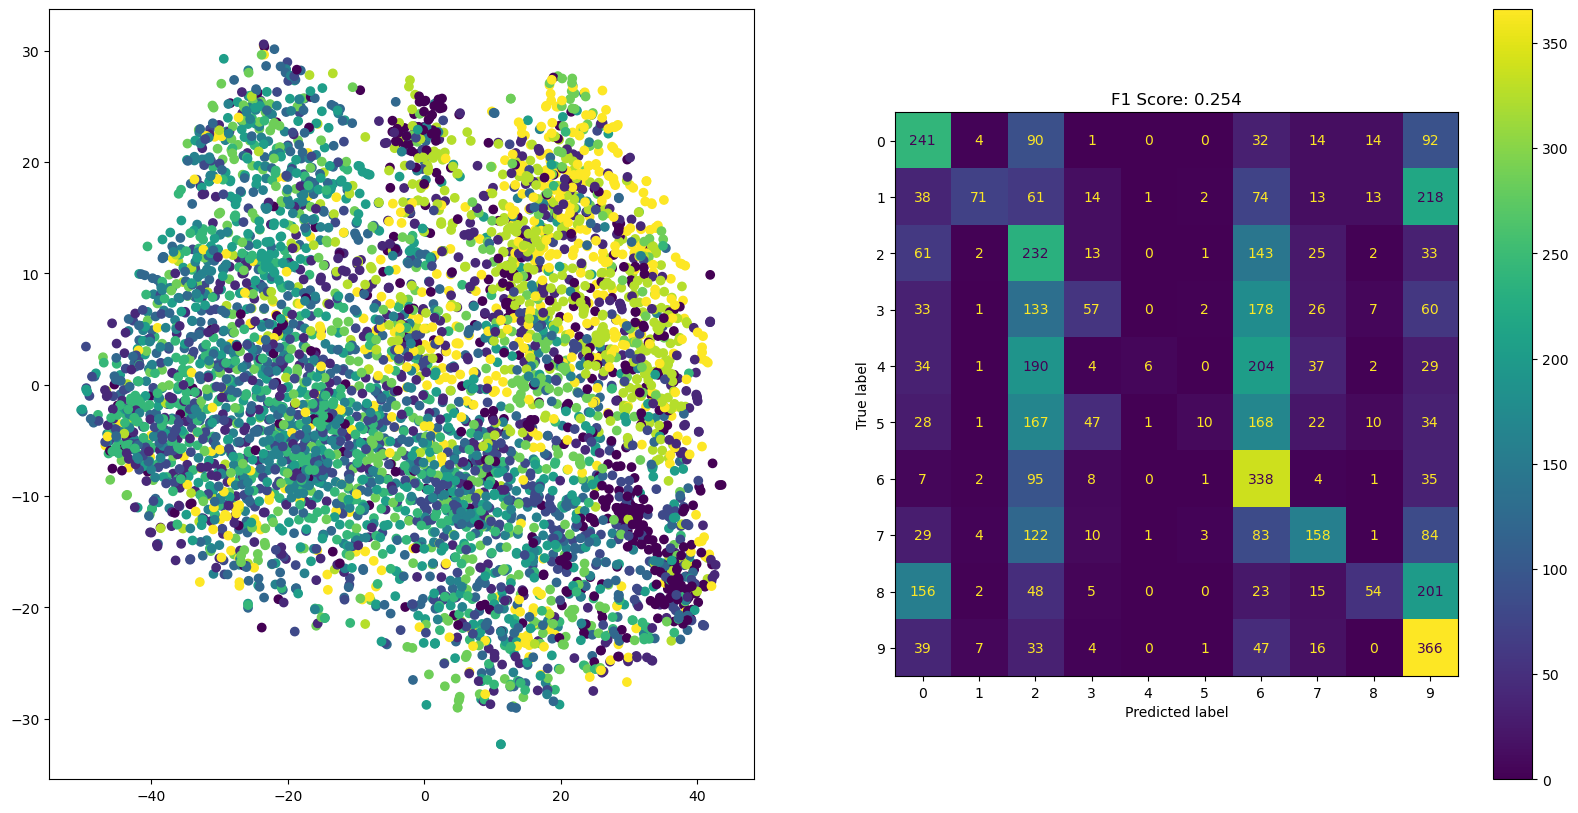

In [4]:
eval_model(x_train_flat, y_train, x_test_flat, y_test)

Considering the performance with the raw pixels, performance is suitably ordinary. The t-SNE plot shows some vague groupings, and our classifier is mediocre. 

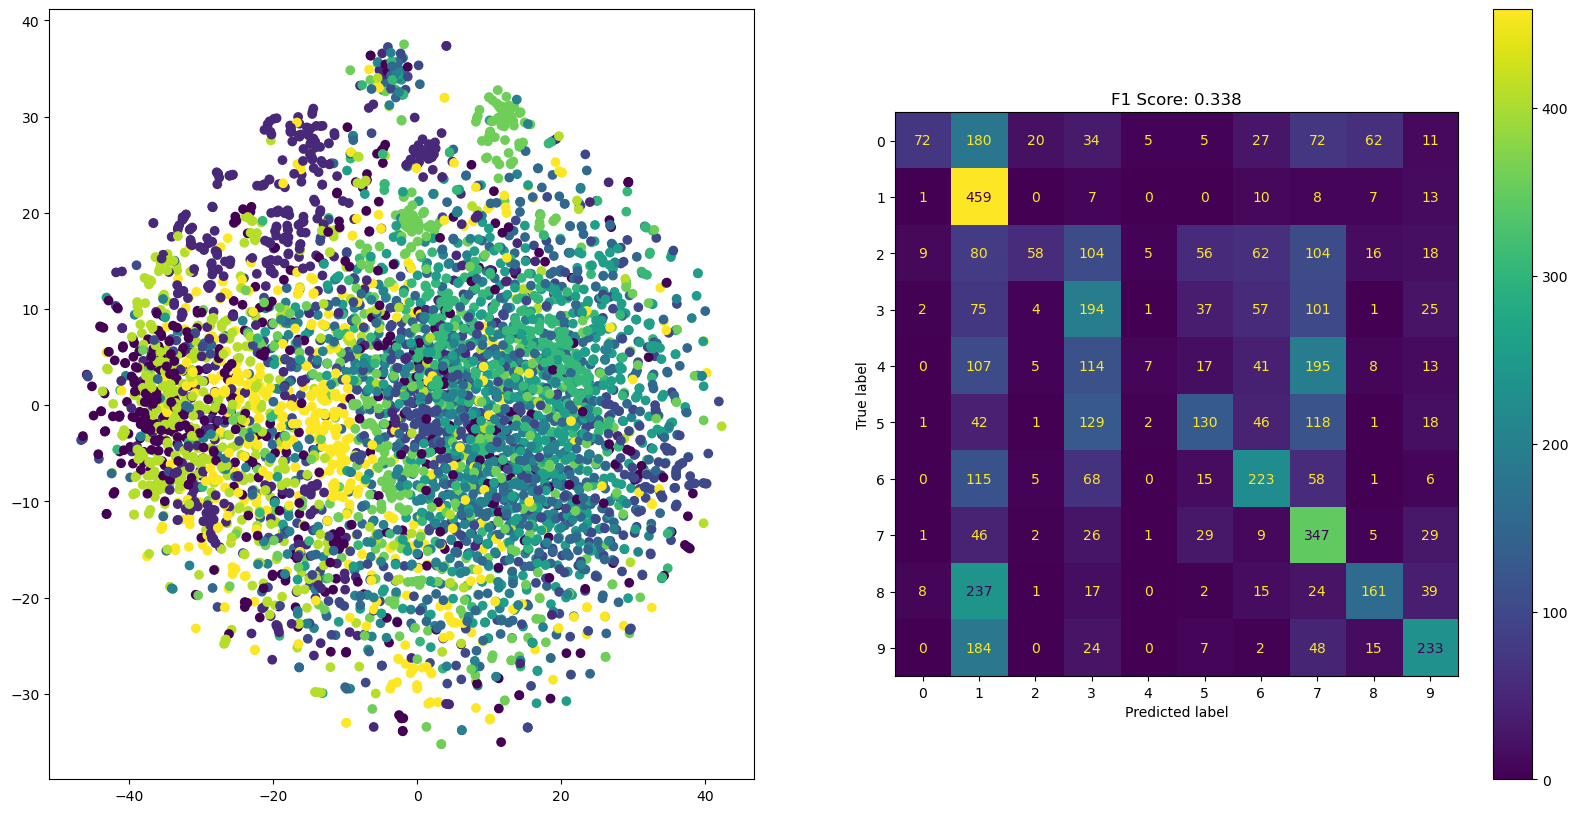

In [5]:
eval_model(x_train_hog, y_train, x_test_hog, y_test)

Considering the HOG features, we immediately see a bump in performance. Things are by no means amazing, but this handcrafted representation is far richer and more discriminative than the raw pixels alone. 

In summary, our baseline results that we'll compare to are:
* F1 of 0.302 for the raw pixels
* F1 of 0.382 for HOG

## Unsupervised Methods

Let's start with our unsupervised methods. We've considered:
* PCA, which learns a projection such that the first dimension contains the most variance, the second contains the second most, and so on. This means that by taking the first N dimensions we take the N dimensions with the most variance, so we can easily select some smaller number of dimensions to capture some amount of variance.
* An auto-encoder (AE), which is a deep learning model that has the same input and output. The AE learns a compressed representation of the data from the data itself.

### PCA on the Raw Pixel Data

We'll start with PCA. Here, we'll consider PCA spaces that capture 95% and 99% of the variance. We'll start with the raw pixel data. When we've used PCA with image data before, we've often see lots of dimensions with very little information. We have $3,072$ dimensions here ($32 \times 32 \times 3$), and again we'd expect to see most of the information in a small number of dimensions.

In [6]:
def train_pca(train, test):
    
    # compute PCA
    pca = decomposition.PCA().fit(train)

    # plot the cumulative sum
    cumulative_sum = numpy.cumsum(pca.explained_variance_ratio_, axis=0)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(cumulative_sum)
    ax.set_title('Cumulative Sum of PCA Explained Variance')
    ax.set_ylabel('Explained Variance')
    ax.set_xlabel('Number of Components')

    # find the numbers of components that give us 95% and 99% of the total variance 
    comp_95 = numpy.where(cumulative_sum > 0.95)[0][0]
    comp_99 = numpy.where(cumulative_sum > 0.99)[0][0]

    # transform the data and pull out the 95% and 99% variance representations
    x_train_pca = pca.transform(train)
    x_test_pca = pca.transform(test)
    
    x_train_pca_95 = x_train_pca[:,0:comp_95]
    x_train_pca_99 = x_train_pca[:,0:comp_99]
    x_test_pca_95 = x_test_pca[:,0:comp_95]
    x_test_pca_99 = x_test_pca[:,0:comp_99]

    # print out the sizes of our representations
    print(x_train_pca.shape)
    print(x_train_pca_95.shape)
    print(x_train_pca_99.shape)
    
    return pca, x_train_pca_95, x_train_pca_99, x_test_pca_95, x_test_pca_99

pca, x_train_pca_95, x_train_pca_99, x_test_pca_95, x_test_pca_99 = train_pca(x_train_flat, x_test_flat)

(10000, 3072)
(10000, 208)
(10000, 624)


We see what we expected. 95% of the variance is in 208 dimensions (about 6.8% of the total number of dimensions), and we have 99% in 624. Lots of our dimensions contain very little information.

In [7]:
eval_model(x_train_pca_95, y_train, x_test_pca_95, y_test)

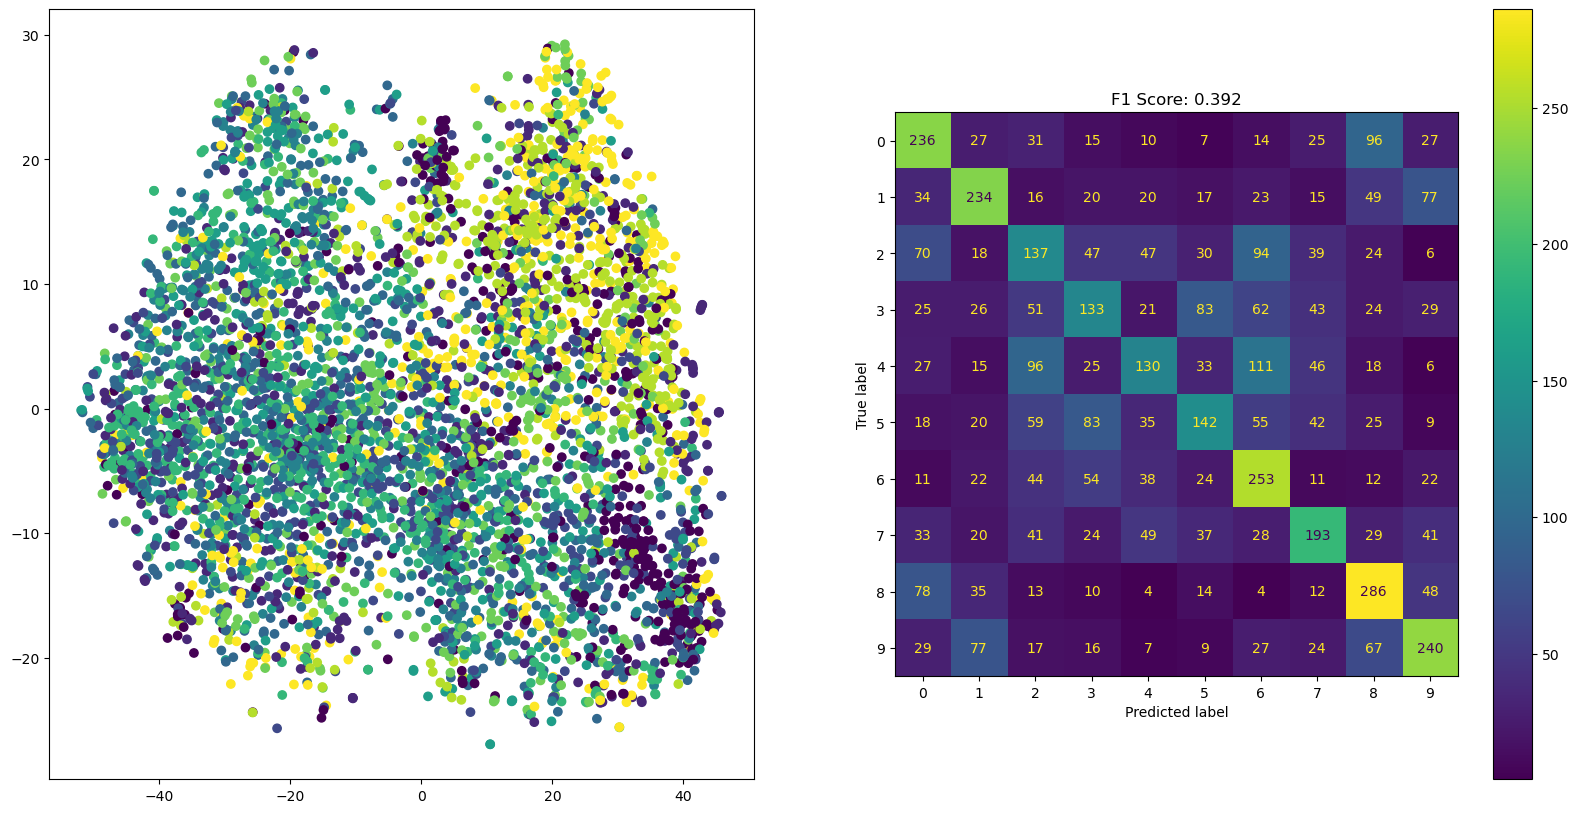

In [8]:
eval_model(x_train_pca_99, y_train, x_test_pca_99, y_test)

Cranking these two representations through we can see we've got a nice bump in performance. Really, we're comparing to the 0.302 F1 score achieved with just the raw pixels, and we hit 0.386 and 0.390 for the 95% and 99% PCA representations respectivley.

We've seen mixed performance with PCA and raw images in the past, but here we get a good performance bump. Let's consider why:
* For our objective this time, fine-grained details in the images are not that important, and in many cases may be more of a distraction. If we consider the face recognition example, we had our first few components capture the overall shape of the face and the lighting, and then we started to get to information specific to identities. Here, there is much less common shape information.
* We have added redundancy through colour, and we can throw away from of that information with less impact.

### PCA with HOG

Let's now through PCA at the HOG data, remembering that with the raw HOG data was much better than the raw pixel data.

(10000, 1568)
(10000, 449)
(10000, 826)


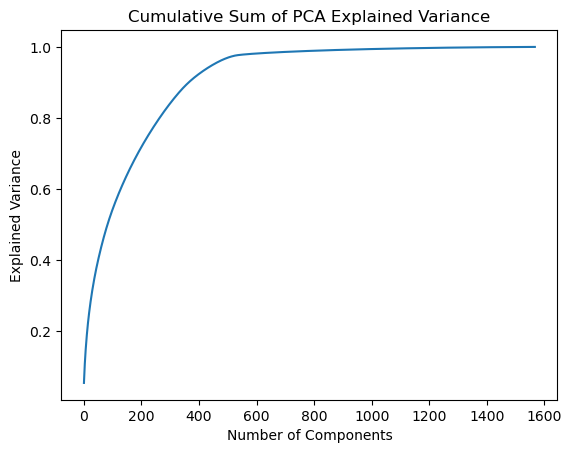

In [9]:
pca, x_train_pca_95, x_train_pca_99, x_test_pca_95, x_test_pca_99 = train_pca(x_train_hog, x_test_hog)

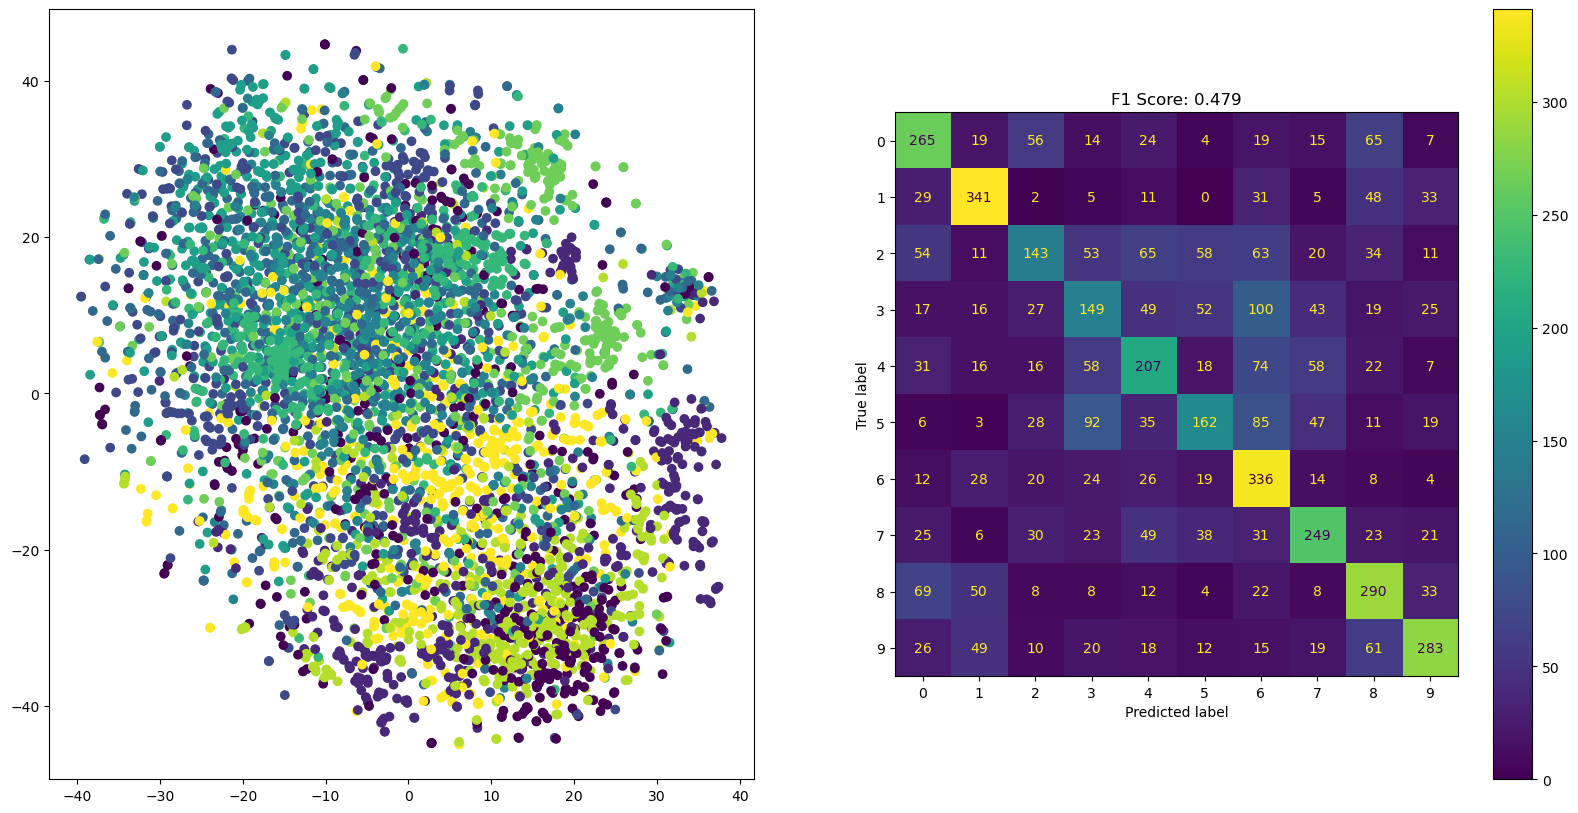

In [10]:
eval_model(x_train_pca_95, y_train, x_test_pca_95, y_test)

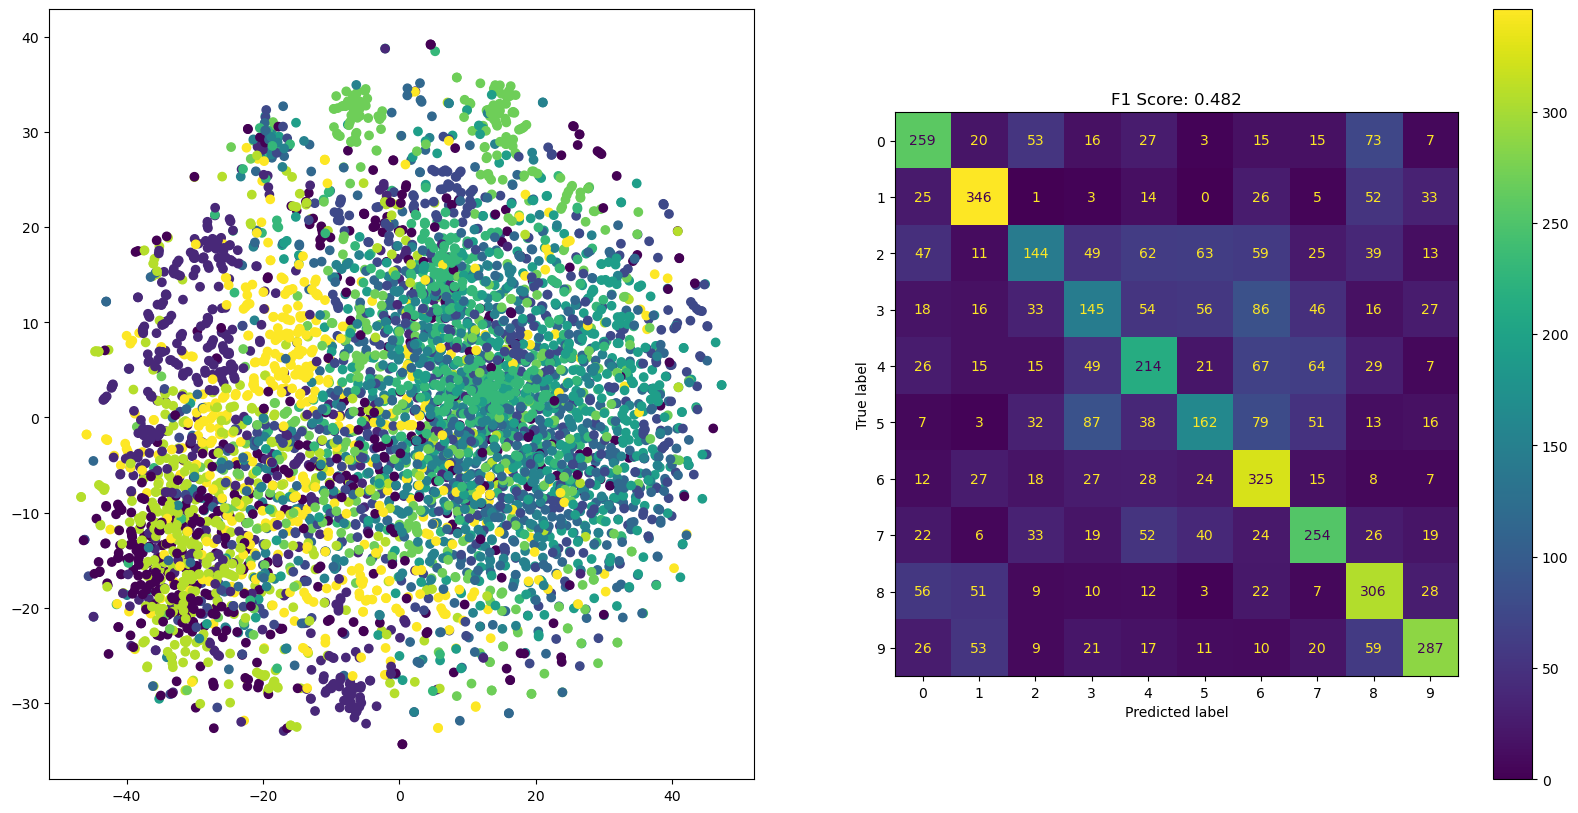

In [11]:
eval_model(x_train_pca_99, y_train, x_test_pca_99, y_test)

Here, we see that we that we have the information spread across more dimensions. There's still a lot of dimensions that don't offer alot, but our 99% representation is using over 50% of the available dimensions. This suggests that there's less redundancy in the data overall, and that we have a richer representation. Given the performance increase we saw when using just the raw data, this makes sense.

Consider the performace with PCA, we again see a nice performance increase (up from 0.382 F1 score).

Considering our performance with PCA, it's worth noting:
* One of PCAs useful features is the ability to transfer in and out of the PCA space, i.e. we take our high dimensional representation, compress it via PCA, and then if we need to reconstruct the original signal. The above evaluation does not consider this at all.
* Our input representation is important. Raw pixels are limited due to all sorts of issues such as lighting variations, pose/position variation, etc. Similar effects exist in other domains (i.e. in audio, the level and type of noise, or the location in a sample of the relevent signal). Using some sort of pre-processing that adds invariance to some (or all?) of these is very helpful.

### An Auto-Encoder (Unsupervised DL)

We'll now throw an auto-encoder at this. One big difference between this auto-encoder and others that we've seen is that I'm not making the representation substantially smaller as I go deeper. It does end up being more compact (512 vs 3,072), but it's not a particularly high amount of compression. This choice is due to two things:
* The purpose of my auto-encoder. Here, I want to learn a good representation for the data. While I want to remove some redundancy from the data, I don't want compactness to the be sole focus of my model; hence having a larger bottleneck is preferable.
* Fairness when comparing to other methods. Below, we're going to use a siamese network (trained with triplet loss) and a semi-supervised network; both of these will use the same encoder as I have here to enable a more fair comparison.

In [12]:
# input, 32x32 colour image
input_img = layers.Input(shape=(32, 32, 3))

# encoder
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# compressed representation
encoded = layers.MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)
# at this point the representation is (32, 4, 4) i.e. 512-dimensional

# decoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', jit_compile=False)
print(autoencoder.summary())
plot_model(autoencoder, show_shapes=True)

history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test), verbose=True)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 8)         │        224 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 16)        │      1,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 16)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 32)          │      4,640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ bottleneck (MaxPooling2D)       │ (None, 4, 4, 32)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 32)          │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 32)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 16)          │      4,624 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 16)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 8)         │      1,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 1)         │         73 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 21,137 (82.57 KB)

 Trainable params: 21,137 (82.57 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.0481 - val_loss: 0.0267
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0244 - val_loss: 0.0211
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0204 - val_loss: 0.0195
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0191 - val_loss: 0.0188
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0183 - val_loss: 0.0180
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0177 - val_loss: 0.0175
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0172 - val_loss: 0.0170
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0169 - val_loss: 0.0169
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0165 - val_loss: 0.0164
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0161 - val_loss: 0.0167
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0162 - val_loss: 0.0160
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0157 -

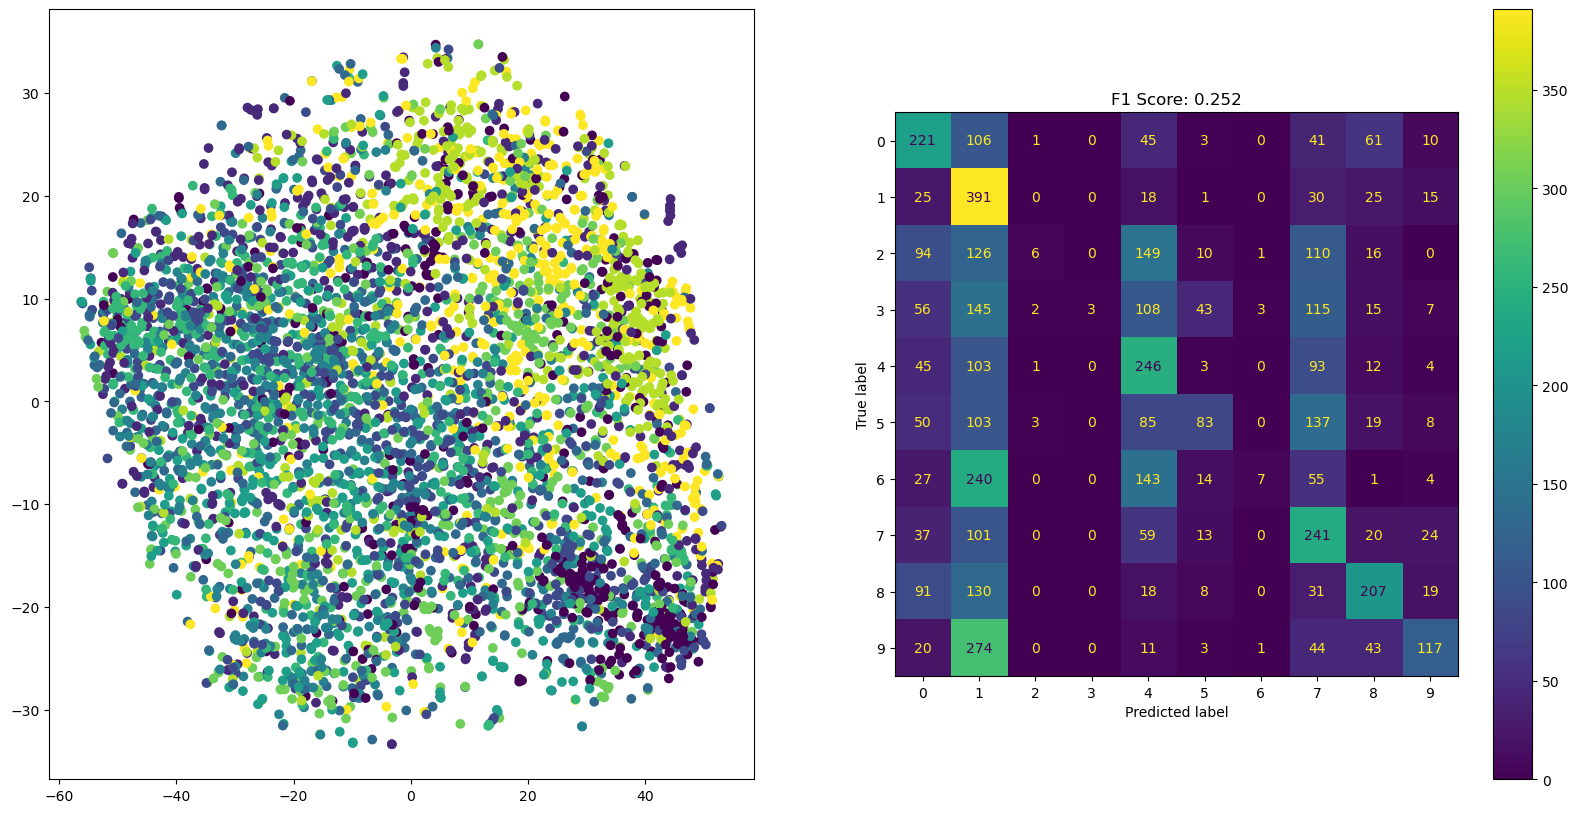

In [13]:
bottleneck_output = autoencoder.get_layer('bottleneck').output 
bottleneck_output = layers.Flatten()(bottleneck_output)
bottleneck_model = keras.Model(inputs = autoencoder.input, outputs = bottleneck_output)

x_train_ae = bottleneck_model.predict(x_train, verbose=False)
x_test_ae = bottleneck_model.predict(x_test, verbose=False)

eval_model(x_train_ae, y_train, x_test_ae, y_test)

The auto-encoder performance is somewhat less than spectacular. There are a few reasons for this:
* We may be retaining information that's not so useful in the bottleneck feature. Making this smaller, training for longer, or adding a sparsity constraint could all help.
* We have very limited data, and deep networks (even unsupervised ones) like lots of data. 

## Supervised Methods

Let's move onto supervised methods now. We'll look at two:
* LDA, our non-deep learning method;
* A siamese network trained with triplet loss, our deep learning version.

### LDA

LDA will try to find a transform that brings points from the same class close together, while pushing points from different classes away from each other. This is usually very good for classification. It will return $C-1$ dimensions, where $C$ is the number of classes (10 in our case). This means that LDA is going to give us our most compact representation yet.

In [14]:
lda = discriminant_analysis.LinearDiscriminantAnalysis().fit(x_train_flat, y_train)
x_train_lda = lda.transform(x_train_flat)
x_test_lda = lda.transform(x_test_flat)
print(x_train_lda.shape)

(10000, 9)


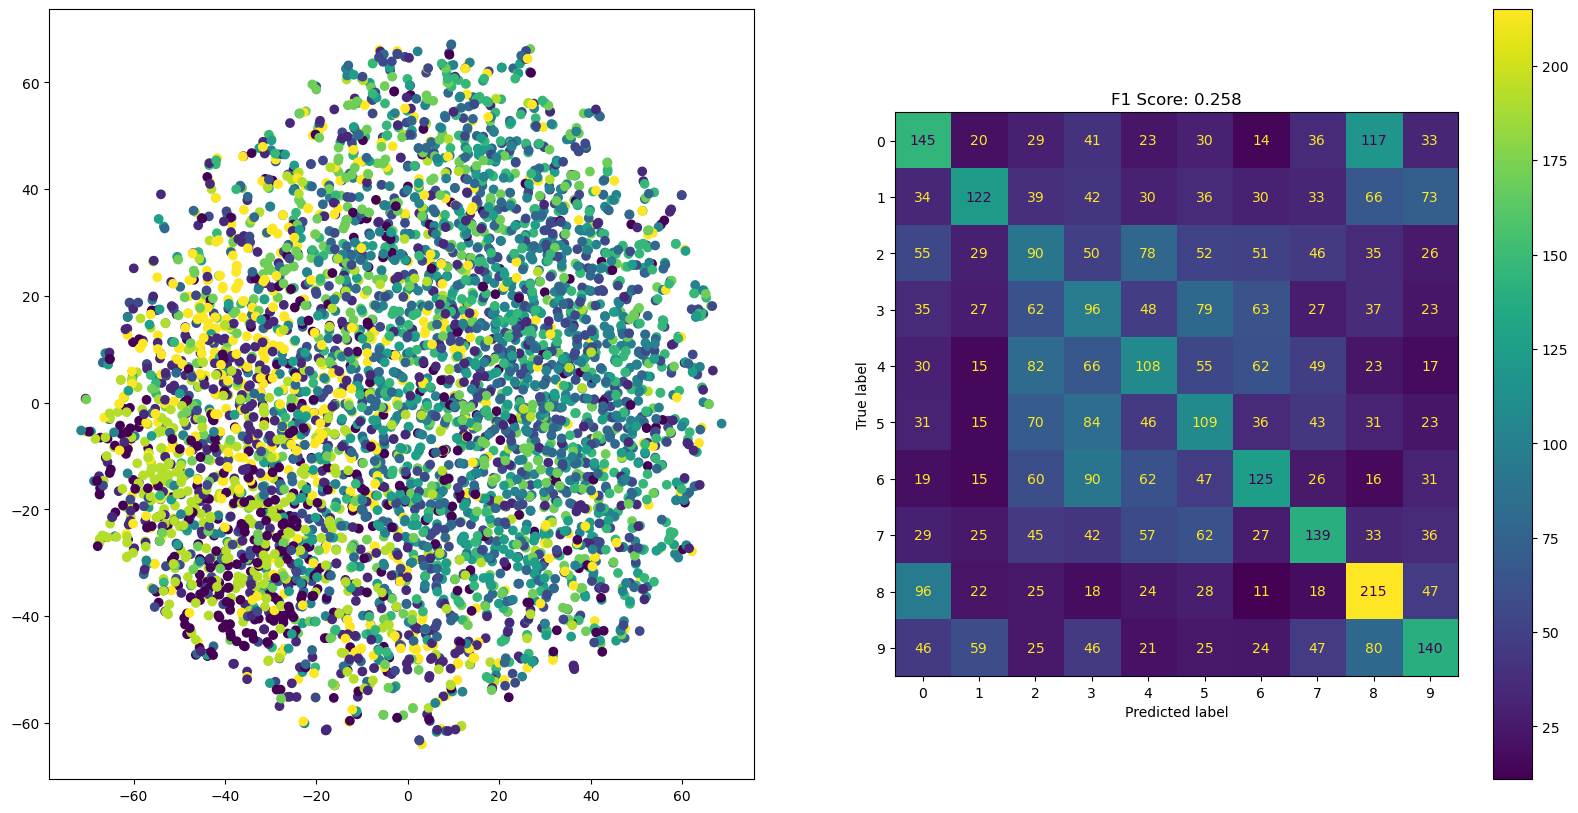

In [15]:
eval_model(x_train_lda, y_train, x_test_lda, y_test)

Performance is poor, and is actually worse than using the raw pixels alone (though the confusion matrix shows more even performance across all classes). What's going on here?

As we saw when playing with the face data, LDA is very sensitive to changes in pose (i.e. alignment of images and so on). We have a lot of variation in this data, so this is likely the issue here - our data is simply too varied. With more constrained/better aligned data we may well see very different performance (try swapping out CIFAR-10 for Fashion MNIST and see what happens).

### LDA with HOG

In [16]:
lda = discriminant_analysis.LinearDiscriminantAnalysis().fit(x_train_hog, y_train)
x_train_lda = lda.transform(x_train_hog)
x_test_lda = lda.transform(x_test_hog)
print(x_train_lda.shape)

(10000, 9)


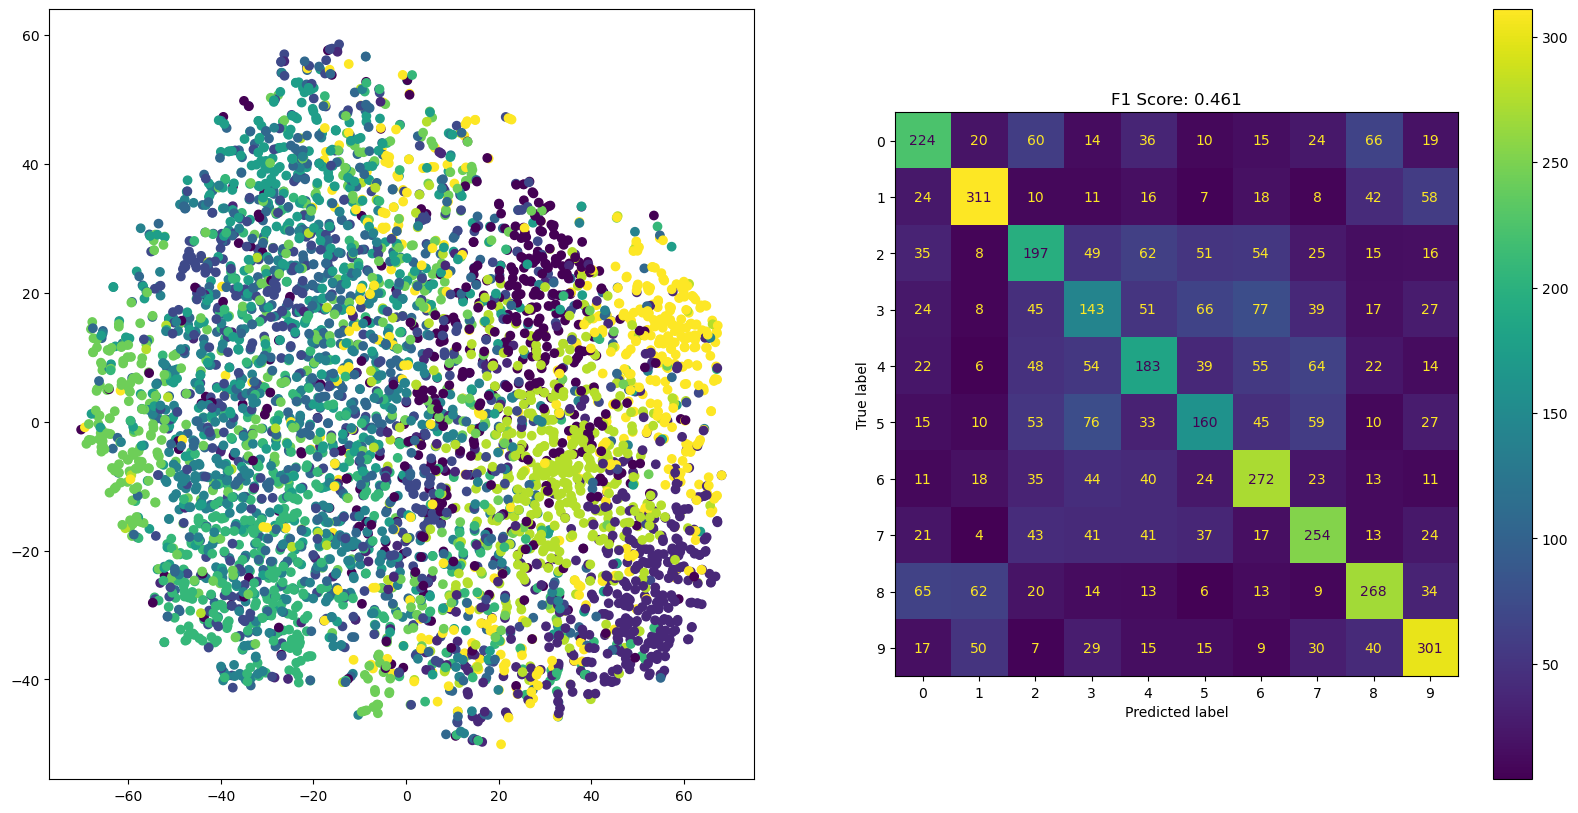

In [17]:
eval_model(x_train_lda, y_train, x_test_lda, y_test)

We see improved performance with HOG, but it's not as good as PCA (though maybe the separation in the t-SNE plot looks better?). Again, we have issues of variation within the data here, and the lack of uniformity in CIFAR-10 does not agree with LDA.

### Metric Learning

On to metric learning now, and in particular a triplet network. This code is all taken from the earlier triplet examples, and if you're unclear of what's happening please refer back to the earlier examples.

In [18]:
def GetTripletData(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_c = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]
        
def normalise_vector(vect):
    # get the magnitude for each vector in the batch
    mag = keras.ops.sqrt(keras.ops.sum(keras.ops.square(vect), axis=1))
    # repeat this, so we now have as many elements in mag as we do in vect
    mag = keras.ops.reshape(keras.ops.repeat(mag, vect.shape[1], axis=0), (-1, vect.shape[1]))
    # element wise division
    return keras.ops.divide(vect, mag)

class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = normalise_vector(anchor)
        positive = normalise_vector(positive)
        negative = normalise_vector(negative)
        
        p_dist = keras.ops.sum(keras.ops.square(anchor-positive), axis=-1)
        n_dist = keras.ops.sum(keras.ops.square(anchor-negative), axis=-1)
        return keras.ops.sum(keras.ops.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
        
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# backbone network
dummy_input = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(dummy_input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
embedding_layer = layers.Dense(32, activation=None)(x)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')

In [19]:
input_anchor = keras.Input((32, 32, 3), name='Anchor')
input_positive = keras.Input((32, 32, 3), name='Positive')
input_negative = keras.Input((32, 32, 3), name='Negative')

embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)

margin = 1
loss_layer = TripletLossLayer(margin)([embedding_anchor, embedding_positive, embedding_negative])
triplet_network = keras.Model(inputs=[input_anchor, input_positive, input_negative], outputs=loss_layer)
triplet_network.compile(optimizer=keras.optimizers.Adam(), jit_compile=False)

batch_size = 128
# fewer triplets than is perhaps ideal here due to memory limits
# ideally, using a generator here would avoid this issue
triplet_train_x = GetTripletData(x_train, y_train, 25000)

history = triplet_network.fit(x = triplet_train_x, y = None, batch_size = batch_size, epochs=10)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 102.1614
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 75.1286
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 60.5663
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 47.8023
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 37.1304
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 27.6660
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 22.1394
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 16.0419
Epoch 9/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12.3859
Epoch 10/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.7999


In [20]:
x_train_triplet = base_network.predict(x_train, verbose=False)
x_test_triplet = base_network.predict(x_test, verbose=False)

eval_model(x_train_triplet, y_train, x_test_triplet, y_test)

This is the best performing network yet. The t-SNE plot looks particularly promising, showing good separation between classes. On the whole, this is not surprising. We've explicitly trained a network to learn similar embeddings (representations) for images of the same class, while keeping images of a different class at least some distance $margin$ away. The end result is a representation that does quite a good job keeping things apart.

As always, we could further improve this by:
* Adding more data, and/or data augmentation
* Making the network and/or embedding bigger

It's worth briefly pausing to reflect on why data augmentation would help here, but would not help with LDA (and PCA) and may in fact make those methods worse. The discussion abovce noted that the variation in the data is a problem for LDA, so wouldn't adding more variation, to help train the model to understand this, be a good thing? The formulation of LDA (and PCA), where each dimension (i.e. pixel) is a feature used to compute the transform, means that they work best when the same pixel always corresponds to the same thing. In a face recognition scenario, this means when the faces are aligned such that the eyes, nose and mouth are always in the same spot. Data augmentation simply does not help with this, as introduces more samples that are not aligned, causing more issues during learning.

For a deep network, we learn progressivley more complex feature representations as we go deeper in the network. Our final set of features (the embedding at the end of the backbone network) do not tie back to particular pixel locations, and operations such as max-pooling, which select the most important (biggest) feature in a region help promote translation invariance. As the model has an amount of invariance "baked-in", data augmentation helps.

For non-DL methods, our best bet is to look at feature representations that promote invariance to factors we'd like to ignore. This is why we see the performance bump with HOG, as this is invariant to (global) illumination changes and offers a limited amount of translation invariance too. Playing further with the HOG settings, or looking at other pre-processing options (bag of visual words? LBP?) would help here.

## Semi-Supervised DL (an Auto-Encoder with an extra loss)

Last method now, and we're going to look at a semi-supervised deep net. Here, we'll pair the autoencoder from above with a simple classification head.

One may argue that we're somewhat cheating here, as we're actually learning a classifer, but we'll give it a go anyway. To make it a bit more fair, we'll drop 98% of the samples. As we only have 10,000 samples, this means that we'll learn the classifier from just 200 samples.

In [21]:
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

# set the mask value. This should be something from outside the existing set of labels
mask_value = -1

# select some elements to mask out
mask_idx = numpy.random.choice(len(y_train_cat), int(len(y_train_cat)*0.98), replace=True)
# copy the array. Note that I use .copy() here. By default python does a "soft copy", i.e. it just creates 
# a pointer to the data. I want to keep an original version of the data in y_train, so I'll use .copy() here
# to do a fully copy of the memory
y_train_masked = y_train_cat.copy()
# set my masked values to -1
y_train_masked[mask_idx] = mask_value
# sanity check time - print out the two and see what happened. 75% of my data should be -1

# semi-supervised cateogorical cross entropy loss. This wil find any rows that have a -1 in the labels
# and remove them from consideration
def masked_cce(y_true, y_pred):
    y_true_masked = tf.boolean_mask(y_true, tf.reduce_any(tf.not_equal(y_true, -1), 1))
    y_pred_masked = tf.boolean_mask(y_pred, tf.reduce_any(tf.not_equal(y_true, -1), 1))
    return keras.ops.mean(keras.ops.categorical_crossentropy(y_true_masked, y_pred_masked))

input_img = layers.Input(shape=(32, 32, 3))

# encoder
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# compressed representation
encoded = layers.MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)
# at this point the representation is (4, 4, 4) i.e. 64-dimensional

# decoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# classifier
xx = layers.Flatten()(encoded)
xx = layers.Dense(256, activation='relu')(xx)
classifier = layers.Dense(10, activation='softmax')(xx)

autoencoder = models.Model(input_img, [decoded, classifier])
autoencoder.compile(optimizer='adam', loss=['mean_squared_error', masked_cce], jit_compile=False)
print(autoencoder.summary())
plot_model(autoencoder, show_shapes=True)

history = autoencoder.fit(x_train, [x_train, y_train_masked],
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, [x_test, y_test_cat]), verbose=True)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 32, 32, 3) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32, 8) │     224 │ input_layer_12[0][0] │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_4     │ (None, 16, 16, 8) │       0 │ conv2d_10[0][0]      │
│ (MaxPooling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │   1,168 │ max_pooling2d_4[0][… │
│                     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_5     │ (None, 8, 8, 16)  │       0 │ conv2d_11[0][0]      │
│ (MaxPooling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 8, 8, 32)  │   4,640 │ max_pooling2d_5[0][… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ bottleneck          │ (None, 4, 4, 32)  │       0 │ conv2d_12[0][0]      │
│ (MaxPooling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 4, 4, 32)  │   9,248 │ bottleneck[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ up_sampling2d_3     │ (None, 8, 8, 32)  │       0 │ conv2d_13[0][0]      │
│ (UpSampling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 8, 8, 16)  │   4,624 │ up_sampling2d_3[0][… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ up_sampling2d_4     │ (None, 16, 16,    │       0 │ conv2d_14[0][0]      │
│ (UpSampling2D)      │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 16, 8) │   1,160 │ up_sampling2d_4[0][… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ flatten_2 (Flatten) │ (None, 512)       │       0 │ bottleneck[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ up_sampling2d_5     │ (None, 32, 32, 8) │       0 │ conv2d_15[0][0]      │
│ (UpSampling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │ 131,328 │ flatten_2[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32, 1) │      73 │ up_sampling2d_5[0][… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_13 (Dense)    │ (None, 10)        │   2,570 │ dense_12[0][0]       │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 155,035 (605.61 KB)

 Trainable params: 155,035 (605.61 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 2.2737 - val_loss: 1.9222
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8176 - val_loss: 1.7405
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6496 - val_loss: 1.6635
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5707 - val_loss: 1.6152
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4866 - val_loss: 1.6458
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4362 - val_loss: 1.5333
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3800 - val_loss: 1.4934
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3255 - val_loss: 1.4770
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2229 - val_loss: 1.4507
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1953 - val_loss: 1.4933
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1461 - val_loss: 1.4219
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0929 - 

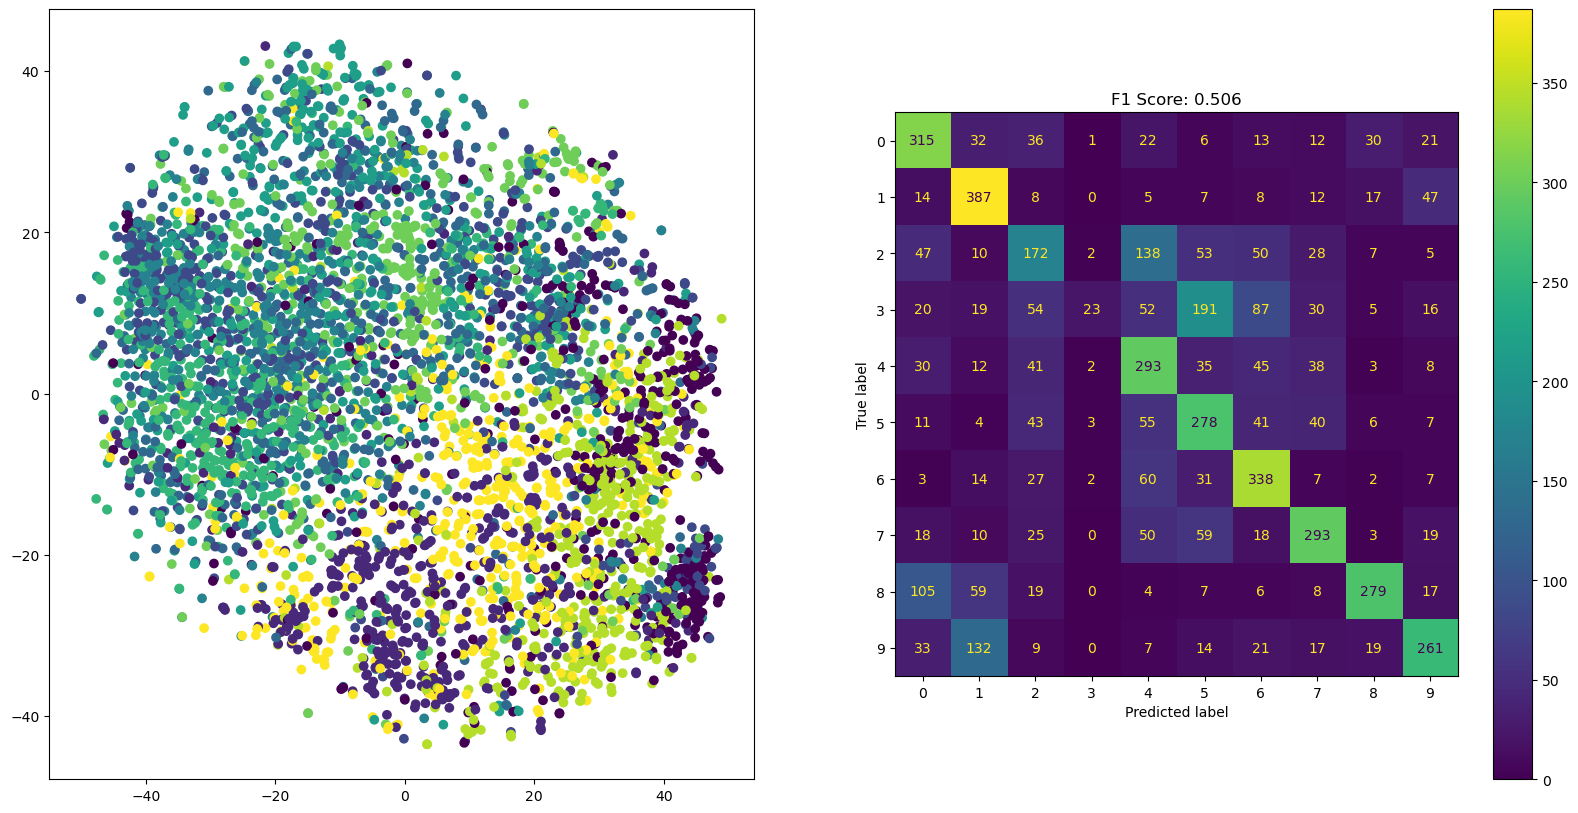

In [22]:
bottleneck_output = autoencoder.get_layer('bottleneck').output 
bottleneck_output = layers.Flatten()(bottleneck_output)
bottleneck_model = keras.Model(inputs = autoencoder.input, outputs = bottleneck_output)

x_train_ss_ae = bottleneck_model.predict(x_train, verbose=False)
x_test_ss_ae = bottleneck_model.predict(x_test, verbose=False)

eval_model(x_train_ss_ae, y_train, x_test_ss_ae, y_test)

Performance wise, the results are a bit interesting. Our classification results are the best we've got. This is not a shock, we've trained the model in part for classification directly (albeit with a very small amount of data), and it's now doing that well. The t-SNE plot however is far less impressive looking than we saw with the triplet network. 

This all comes down to the way that we've trained the two networks, and the simple fact that the triplet loss is not classification. The triplet loss is all about manipulating the embedding space to get some desireable properties there (items of the same class being close together). While this property is helpful for classification, it is not necessary (or at least not necessary for fairly middling classification results). As such, we don't see the same clear separation in the t-SNE plot in our semi-supervised example.

## Final Thoughts and Things to Try

The above example has covered the various ways that we can learn a representation of data in brief, but there are a lot of other things that could be explored. In particular:
* Use different data. What happens is the data has less variation than CIFAR-10? Try one of the MNIST variants and see what happens.
* Change the deep network used. Make this more complex, or simpler. Add a sparsity constraint. See what happens.
* Look at other representations that you could use with PCA and LDA. This could be LBP, or bag of visual words. Or just play with the HOG settings.
* Combine things. Use LDA after PCA. Or even use LDA after an auto-encoder.